In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 0.20 (18-10-2022)' )

loaded gammapy version: 0.20 
Supposed to be 0.20 (18-10-2022)


In this notebook the angular size of the systematic is evaulated. Therefore, we compute the sqrt ts map of the standard anlysis and compute the 2D Fourier trafo of the first energybin. The obtained angular spectrum is compared with the one computed from a dataset consisting of statistical fluctuations only (asimov dataset). The spectrum of 1000 Poission draws of this asimov dataset are plotted and used for the standard deviation estimation of the anuglar spectrum points. 

In [4]:
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import astropy
from gammapy.maps import Map
from gammapy.datasets import MapDataset
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from astropy.coordinates import SkyCoord, Angle
from regions import RectangleSkyRegion

import astropy.units as u
import yaml
import sys
#sys.path.append('/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters')

import my_dataset_maps_20


spatial binsize =  [0.02] deg


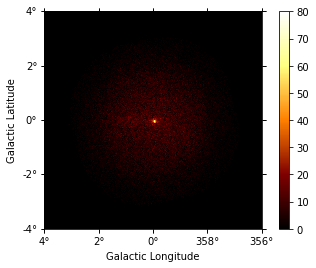

In [8]:
source = 'GC_dataset_zeta_5_muoneffTrue_edispTrue'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'

if source == "Crab":

    # here the dataset with the fine binning is saved
    dataset = MapDataset.read(f'{path}/{source}/stacked.fits')
    dataset = dataset.downsample(4)
    models = Models.read(f"{source}/standard_model.yml")
    
    with open(f"{source}/nui_bgmodel.yml", "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
    bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
    models.append(bkg_model)
    dataset.models = models


    
if "GC" in source:
    if source =="GC":
        path_GC ='/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_0.19'
        dataset = MapDataset.read(f'{path_GC}/20220511_dataset002_hess1_muonflagTrue.fits')
        dataset.stack(MapDataset.read(f'{path_GC}/20220511_dataset002_hess2_muonflagTrue.fits'))
        dataset = dataset.downsample(4)
        
    if source == 'GC_dataset_zeta_1_muoneffTrue_edispTrue':
        path_GC = '/home/vault/caph/mppi062h/repositories/GC/HESS/datasets_fits'
        dataset = MapDataset.read(f'{path_GC}/dataset_zeta_1_muoneffTrue_edispTrue.fits')
   
    if source == 'GC_dataset_zeta_5_muoneffTrue_edispTrue':
        path_GC = '/home/vault/caph/mppi062h/repositories/GC/HESS/datasets_fits'
        dataset = MapDataset.read(f'{path_GC}/dataset_zeta_1_muoneffTrue_edispTrue.fits')
   

    
    
dataset.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset.geoms["geom"].width[1] / dataset.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)


## Statistics Check

(24,)
sys_percent [  0.           0.           0.           0.          -8.60016303
   9.48037732   1.13561975   1.54666047  -5.84703186  -2.10129631
   3.20831794  -3.16167181  -7.42095954   7.06644365 -13.07683678
 -16.15137174 -22.38051537 -23.01900187 -24.23767242 -30.63909496
   0.           0.           0.           0.        ]
stat_percent [       nan        nan        nan 0.8465507  0.4642009  0.51549035
 0.53067744 0.5908925  0.67640877 0.7787235  0.88525444 1.0692341
 1.2699738  1.712568   2.351181   2.743503   3.2545912  3.8613503
 4.587612   5.4714046  6.392357   7.4781575  8.783543   9.893345  ]


/tmp/ipykernel_937654/1381194023.py:10: RuntimeWarning: invalid value encountered in true_divide
  stat_percent = stat_counts/ bg  * 100


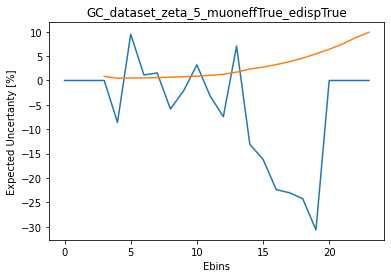

In [12]:
sys_percent = np.loadtxt(f'{source}/sysamplitude_percentage.txt')
plt.plot(sys_percent, label = 'sys')
plt.ylabel("Expected Uncertanty [%]")
plt.xlabel("Ebins")
bg = dataset.background.data.sum(axis=2).sum(axis=1)
print(np.shape(sys_percent))
sys_counts = sys_percent * bg /100

stat_counts = np.sqrt(bg)  
stat_percent = stat_counts/ bg  * 100
print('sys_percent', sys_percent)
print("stat_percent", stat_percent )
plt.plot(stat_percent, label = 'stat')
fig = plt.gcf()
plt.title(source)
name = f'{source}'+'/plots/stat_sys_comparison_percent'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')

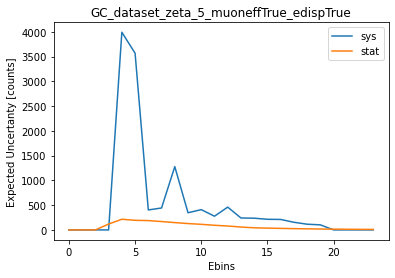

In [11]:
plt.plot(np.abs(sys_counts), label = "sys")
plt.plot(stat_counts, label = 'stat')
plt.ylabel("Expected Uncertanty [counts]")
plt.xlabel("Ebins")
plt.legend()
fig = plt.gcf()
plt.title(source)

name = f'{source}'+'/plots/stat_sys_comparison_counts'  
fig.savefig(name+'.png', dpi=300, bbox_inches = 'tight')